In [36]:
%load_ext autoreload
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
%aimport exv2.experiment_results 

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import glasbey



pd.set_option('display.max_columns', None)
sns.set_theme(rc={'figure.figsize':(12, 6)})
sns.set_context("paper")
sns.set_style("whitegrid")

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

palette = glasbey.create_block_palette(
    [4, 3, 3, 2, 2],
    colorblind_safe=True,
    cvd_severity=90
)
sns.set_palette(palette)

dep_focus = ["baseline_vanilla_full","monolith_feature_monolith_full","serverless_feature_serverless_full"]
ms_focus = ["baseline_vanilla_full","obs_feature_object-storage_full","norec_feature_norecommendations_full"]
lable_names = {
    "baseline_vanilla_full": "Microservice Baseline",
    'jvm_jvm-impoove_full': "Runtime Improvement",
    'monolith_feature_monolith_full': "Monolith Variant",
    'norec_feature_norecommendations_full' : "Service Reduction",
    'obs_feature_object-storage_full' : "Infrastructure Service Replacement",
    'serverless_feature_serverless_full' : "Serverless Variant",
}

In [40]:
exr = exv2.experiment_results.ExperimentResults("data/clean_run*", load_stats_history=True, remove_outliers=False) # type: ignore
RUN_VARS = exv2.experiment_results.ExperimentResults.RUN_VARS # type: ignore

assert("loadgenerator" not in (list(exr.pods['name'].unique())))
assert("unkown" not in (list(exr.pods['instance'].unique())))


/Users/b/projects/teastore_experiments/exv2/experiment_results.py:188: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  def absolute_requests_per_branch(self) -> pd.DataFrame:


In [261]:
pods = exr.pods.copy()
pods["type"] = pods["pod_name"].apply(lambda x: "pod" if x.startswith("teastore") else "function" if x.startswith("auth") else "infra")
pods = pods[pods["type"] != "infra"]
pods["service"] = pods["pod_name"].apply(lambda x: "-".join(x.split("-")[0:2]))
pods["service"].unique()
pods.set_index("run_time")
# pods["run_time"] = pods["run_time"].transform(lambda x: int(x.total_seconds()))

pods_scale = pods.groupby(["exp_branch","exp_workload","run_iteration","run_time","service"])["name"].count().reset_index()

general_allowance = {
    "teastore-recommender": {"cpu": 2600, "memory": 1332},
    "teastore-webui": {"cpu": 1300, "memory": 1950},
    "teastore-image": {"cpu": 1300, "memory": 1950},
    "teastore-auth": {"cpu": 585, "memory": 1332},
    'teastore-registry':{"cpu": 1300, "memory": 1332}, # not set by default ....
    'teastore-persistence':{"cpu": 1300, "memory": 1332}, # not set by default ....
    'teastore-db':{"cpu": 1300, "memory": 1332}, # not set by default ....
    "teastore-all": {"cpu":1950, "memory":2663},
    "auth": {"cpu": 500, "memory": 500},
}



def calulate_resouce_allowence(row):
    if not row["service"] in general_allowance.keys() and not row["service"].startswith("auth") :
        return row
    else:
        
        if row["service"].startswith("auth"):
            cpu = general_allowance["auth"]["cpu"]
            memory = general_allowance["auth"]["memory"]
        else:
            cpu = general_allowance[row["service"]]["cpu"]
            memory = general_allowance[row["service"]]["memory"]
        row["cpu_limit"] = cpu 
        row["mem_limit"] = memory 
        
        return row

pods = pods.apply(calulate_resouce_allowence, axis=1, result_type="expand")

pods["mem_utilization"] = 100*pods["memory_usage"] / pods["mem_limit"]
pods["cpu_utilization"] = 100*(1000*pods["cpu_usage"]) / pods["cpu_limit"]

pods["under_utilized"] = 1
pods.loc[(pods["mem_utilization"] < 49) & (pods["cpu_utilization"] < 49),"under_utilized"] = 0

pods["over_utilized"] = 1
pods.loc[(pods["mem_utilization"] > 90) | (pods["cpu_utilization"] > 90),"over_utilized"] = 0

pod_scaling_behavior = pods.groupby(["exp_branch","exp_workload","run_iteration"]+["service","run_time"])[["under_utilized","over_utilized","wattage_kepler"]].agg(["sum","count"])
service_utilization = pod_scaling_behavior
service_utilization["under"] = service_utilization[("under_utilized","count")] - service_utilization[("under_utilized","sum")]
service_utilization["over"] =  service_utilization[("over_utilized","count")] - service_utilization[("over_utilized","sum")]
service_utilization["count"] = service_utilization[("over_utilized","count")]
service_utilization.loc[(service_utilization["count"] == 1) & (service_utilization["under"]==1),"under"] = 0
service_utilization.loc[(service_utilization["count"] == 3) & (service_utilization["over"]==3),"over"] = 0
service_utilization.loc[(service_utilization["under"] > 0) | (service_utilization["over"]>0),"waste"] = service_utilization[("wattage_kepler","sum")]

# service_utilization = service_utilization[["exp_branch","exp_workload","run_iteration"]+["service","run_time"]+["under","over"]].reset_index()
service_utilization.columns = service_utilization.columns.droplevel(1)
service_utilization = service_utilization.reset_index()[["exp_branch","exp_workload","run_iteration","service","run_time","under","over","count","waste"]]

melt_service_utilization =  service_utilization.melt(id_vars=["exp_branch","exp_workload","run_iteration"]+["service","run_time"], value_vars=["under","over"])


service_utilization_error = melt_service_utilization[melt_service_utilization["value"] > 0].groupby(["exp_branch","exp_workload","run_time"])["value"].sum().reset_index()

scaling_error =  melt_service_utilization.groupby(["exp_branch","exp_workload"])["value"].sum().reset_index()
scaling_error

,exp_branch,exp_workload,value
0,baseline_vanilla_full,exp_scale_fixed,10
1,baseline_vanilla_full,exp_scale_pausing,46
2,baseline_vanilla_full,exp_scale_rampup,567
3,baseline_vanilla_full,exp_scale_shaped,96
4,jvm_jvm-impoove_full,exp_scale_fixed,0
5,jvm_jvm-impoove_full,exp_scale_pausing,0
6,jvm_jvm-impoove_full,exp_scale_rampup,723
7,jvm_jvm-impoove_full,exp_scale_shaped,0
8,monolith_feature_monolith_full,exp_scale_fixed,0
9,monolith_feature_monolith_full,exp_scale_pausing,0


/var/folders/38/12xcnc5j0nz1sv3x5wj08c1w0000gn/T/ipykernel_29150/646536574.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([lable_names[x.get_text()] for x in ax.get_yticklabels()])


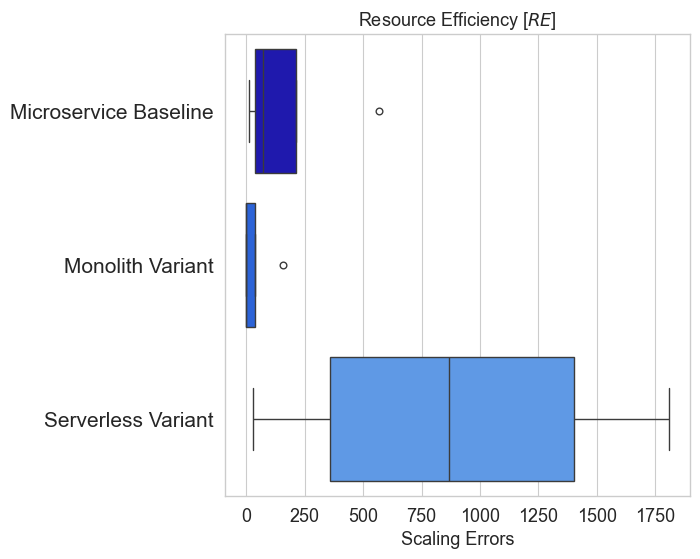

In [269]:
fig, ax = plt.subplots(1,1,figsize=(6, 6))
sns.set_context(rc={"font.size": 13, "axes.titlesize": 13, "axes.labelsize": 13, "xtick.labelsize": 13, "ytick.labelsize": 15})
sns.boxplot(
    data=scaling_error[scaling_error["exp_branch"].isin(dep_focus)],
    y="exp_branch",
    x="value",
    hue="exp_branch",
    ax=ax
)

ax.set_title("Resource Efficiency [$RE$]")
ax.set_ylabel("")
ax.set_xlabel("Scaling Errors")
ax.set_yticklabels([lable_names[x.get_text()] for x in ax.get_yticklabels()])
fig.savefig("figs/scaling_errors.pdf", bbox_inches='tight')

/var/folders/38/12xcnc5j0nz1sv3x5wj08c1w0000gn/T/ipykernel_29150/4249879385.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([lable_names[x.get_text()] for x in ax.get_yticklabels()])


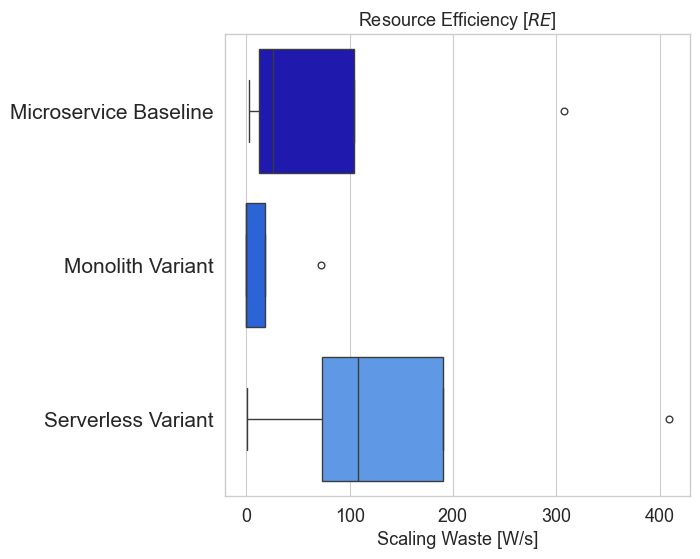

In [268]:
scaling_waste = service_utilization.groupby(["exp_branch","exp_workload"])["waste"].sum().reset_index()

fig, ax = plt.subplots(1,1,figsize=(6, 6))
sns.set_context(rc={"font.size": 13, "axes.titlesize": 13, "axes.labelsize": 13, "xtick.labelsize": 13, "ytick.labelsize": 15})
sns.boxplot(
    data=scaling_waste[scaling_waste["exp_branch"].isin(dep_focus)],
    y="exp_branch",
    x="waste",
    hue="exp_branch",
    ax=ax
)

ax.set_title("Resource Efficiency [$RE$]")
ax.set_ylabel("")
ax.set_xlabel("Scaling Waste [W/s]")
ax.set_yticklabels([lable_names[x.get_text()] for x in ax.get_yticklabels()])
fig.savefig("figs/scaling_waste.pdf", bbox_inches='tight')